# 5. BIST50 Çoklu Hisse Derin Öğrenme Analizi

**Amaç:** RNN, LSTM, CNN, MLP modellerini 50 hisse ile eğitmek

**Hipotez:** Veri miktarı artınca (250 → 12,500 sample), derin öğrenme modelleri çok daha iyi performans gösterecek

**Karşılaştırma:**
- 1_bist50_DL.ipynb → 1 hisse, 250 sample
- 5_bist50_full_DL.ipynb → 50 hisse, 12,500 sample (44x daha fazla!)


## 1. Kurulum ve Ortam Ayarları

In [1]:
# Google Drive'ı mount et
from google.colab import drive
drive.mount('/content/drive')

import os

# Veri ve sonuçlar klasörlerini ayarla
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/tez/Data/BIST_50_2018_Data_Full_Imputed.csv'
RESULTS_DIR = '/content/drive/MyDrive/Colab Notebooks/Sonuclar/5_DeepLearning_Full'
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f" Drive mounted")
print(f" Veri dosyası: {DATA_PATH}")
print(f" Sonuçlar klasörü: {RESULTS_DIR}")

# Dosya varlık kontrolü
if not os.path.exists(DATA_PATH):
 print(f"\n HATA: Veri dosyası bulunamadı!")
 print(f" Lütfen BIST_50_2018_Data_Full_Imputed.csv dosyasını .../tez/Data/ klasörüne kopyalayın")
 raise FileNotFoundError(DATA_PATH)

Mounted at /content/drive
 Drive mounted
 Veri dosyası: /content/drive/MyDrive/Colab Notebooks/tez/Data/BIST_50_2018_Data_Full_Imputed.csv
 Sonuçlar klasörü: /content/drive/MyDrive/Colab Notebooks/Sonuclar/5_DeepLearning_Full


In [2]:
# Temel kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(" Kütüphaneler yüklendi")
print(f" TensorFlow version: {tf.__version__}")
print(f" NumPy version: {np.__version__}")
print(f" Pandas version: {pd.__version__}")

# GPU kontrolü
print(f"\n GPU Durumu:")
print(f" GPU mevcut mu: {tf.test.is_gpu_available()}")
print(f" GPU cihazları: {tf.config.list_physical_devices('GPU')}")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


 Kütüphaneler yüklendi
 TensorFlow version: 2.19.0
 NumPy version: 2.0.2
 Pandas version: 2.2.2

 GPU Durumu:
 GPU mevcut mu: True
 GPU cihazları: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Veri Setinin Yüklenmesi ve Ön İşleme

In [3]:
print("="*80)
print(" VERİ YÜKLEME")
print("="*80)

# CSV'yi oku
df = pd.read_csv(DATA_PATH)

print(f" Veri yüklendi!")
print(f" Toplam Satır: {len(df):,}")
print(f" Toplam Sütun: {len(df.columns):,}")

# Tarihi düzelt
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')

# Hisse listesini çıkar
all_columns = df.columns.tolist()
stock_tickers = []
for col in all_columns:
    if col != 'Date' and '_Now' in col:
        ticker = col.replace('_Now', '')
        stock_tickers.append(ticker)

print(f"\nToplam Hisse: {len(stock_tickers)}")
print(f"İlk 10 Hisse: {stock_tickers[:10]}")

df.head()

 VERİ YÜKLEME
 Veri yüklendi!
 Toplam Satır: 250
 Toplam Sütun: 301

Toplam Hisse: 50
İlk 10 Hisse: ['AEFES', 'AKBNK', 'ALBRK', 'ARCLK', 'ASELS', 'AYGAZ', 'BIMAS', 'BRISA', 'CCOLA', 'CIMSA']


,Date,AEFES_Now,AEFES_Open,AEFES_High,AEFES_Low,AEFES_Volume,AEFES_Diff%,AKBNK_Now,AKBNK_Open,AKBNK_High,...,VESTL_High,VESTL_Low,VESTL_Volume,VESTL_Diff%,YKBNK_Now,YKBNK_Open,YKBNK_High,YKBNK_Low,YKBNK_Volume,YKBNK_Diff%
0,2018-01-02,"1,77","2,44","2,48","2,39","6,99M","-2,40%","6,66","8,45","8,70",...,"8,93","7,61","98,14M","-0,90%","2,38","2,81","2,87","2,80","60,64M","0,23%"
1,2018-01-03,"1,82","2,44","2,51","2,42","13,27M","-0,16%","6,56","8,68","8,75",...,"9,69","8,66","122,76M","0,23%","2,38","2,86","2,90","2,83","44,09M","0,23%"
2,2018-01-04,"1,82","2,49","2,52","2,49","7,91M","-1,19%","6,50","8,52","8,69",...,"9,25","8,73","37,26M","-0,34%","2,37","2,85","2,89","2,82","32,27M","-0,90%"
3,2018-01-05,"1,84","2,50","2,54","2,48","8,56M","-0,39%","6,64","8,49","8,66",...,"9,14","8,85","17,53M","-1,55%","2,39","2,85","2,89","2,85","28,01M","0,45%"
4,2018-01-08,"1,85","2,54","2,56","2,52","9,71M","-0,16%","6,56","8,69","8,74",...,"9,12","8,90","22,33M","-2,06%","2,38","2,90","2,90","2,85","27,82M","1,14%"


In [4]:
def parse_turkish_number(value):
    """Türk formatındaki sayıyı float'a çevir (1.234,56 → 1234.56)"""
    if pd.isna(value) or value == '' or value is None:
        return np.nan

    try:
        value = str(value).strip()

        if not value or value == 'nan':
            return np.nan

        # M ve B için
        if 'M' in value:
            value = value.replace('M', '').replace(',', '.').strip()
            return float(value) * 1_000_000
        elif 'B' in value:
            value = value.replace('B', '').replace(',', '.').strip()
            return float(value) * 1_000_000_000

        # Normal sayı: 1.234,56 → 1234.56
        value = value.replace('.', '')  # Binlik ayracı
        value = value.replace(',', '.')  # Ondalık ayracı
        value = value.replace('%', '')  # Yüzde

        return float(value)
    except:
        return np.nan

# Tüm sayısal kolonları dönüştür
print(" Sayısal veriler dönüştürülüyor...")

for ticker in stock_tickers:
    for col_type in ['Now', 'Open', 'High', 'Low', 'Volume']:
        col_name = f'{ticker}_{col_type}'
        if col_name in df.columns:
            df[col_name] = df[col_name].apply(parse_turkish_number)

    diff_col = f'{ticker}_Diff%'
    if diff_col in df.columns:
        df[diff_col] = df[diff_col].apply(parse_turkish_number)

print(" Veri dönüştürme tamamlandı")
print(f"\n Örnek Veri (AKBNK):")
print(df[['Date', 'AKBNK_Now', 'AKBNK_Open', 'AKBNK_Volume']].head())

 Sayısal veriler dönüştürülüyor...
 Veri dönüştürme tamamlandı

 Örnek Veri (AKBNK):
        Date  AKBNK_Now  AKBNK_Open  AKBNK_Volume
0 2018-01-02       6.66        8.45    22350000.0
1 2018-01-03       6.56        8.68    20360000.0
2 2018-01-04       6.50        8.52    27610000.0
3 2018-01-05       6.64        8.49    23810000.0
4 2018-01-08       6.56        8.69    18040000.0


## 3. Çoklu Hisse Veri Seti Oluşturma

In [5]:
print("="*80)
print(" MULTI-STOCK DATASET OLUŞTURMA")
print("="*80)

# Long format'a dönüştür
data_list = []

for ticker in stock_tickers:
 for idx, row in df.iterrows():
     data_list.append({
 'Date': row['Date'],
 'Ticker': ticker,
 'Now': row[f'{ticker}_Now'],
 'Open': row[f'{ticker}_Open'],
 'High': row[f'{ticker}_High'],
 'Low': row[f'{ticker}_Low'],
 'Volume': row[f'{ticker}_Volume'],
 'Diff_pct': row[f'{ticker}_Diff%']
 })

df_long = pd.DataFrame(data_list)

print(f" Long format oluşturuldu!")
print(f" Toplam satır: {len(df_long):,}")
print(f" 50 hisse × {len(df)} gün = {len(df_long):,} sample")

# NaN kontrolü
print(f"\n NaN değer sayısı:")
print(df_long.isna().sum())

# NaN'ları temizle
df_long = df_long.dropna()
print(f"\n Temizleme sonrası: {len(df_long):,} sample")

df_long.head(10)

 MULTI-STOCK DATASET OLUŞTURMA
 Long format oluşturuldu!
 Toplam satır: 12,500
 50 hisse × 250 gün = 12,500 sample

 NaN değer sayısı:
Date        0
Ticker      0
Now         0
Open        0
High        0
Low         0
Volume      0
Diff_pct    0
dtype: int64

 Temizleme sonrası: 12,500 sample


,Date,Ticker,Now,Open,High,Low,Volume,Diff_pct
0,2018-01-02,AEFES,1.77,2.44,2.48,2.39,6990000.0,-2.40
1,2018-01-03,AEFES,1.82,2.44,2.51,2.42,13270000.0,-0.16
2,2018-01-04,AEFES,1.82,2.49,2.52,2.49,7910000.0,-1.19
3,2018-01-05,AEFES,1.84,2.50,2.54,2.48,8560000.0,-0.39
4,2018-01-08,AEFES,1.85,2.54,2.56,2.52,9710000.0,-0.16
5,2018-01-09,AEFES,1.85,2.53,2.55,2.52,4300000.0,-0.24
6,2018-01-10,AEFES,1.86,2.55,2.56,2.53,3250000.0,-1.54
7,2018-01-11,AEFES,1.89,2.57,2.59,2.53,109900000.0,-0.38
8,2018-01-12,AEFES,1.89,2.59,2.62,2.59,11330000.0,-0.15
9,2018-01-15,AEFES,1.90,2.56,2.63,2.56,7880000.0,-0.23


In [6]:
print("="*80)
print(" TEKNİK GÖSTERGELER EKLEME")
print("="*80)

# Hisse bazında grupla ve sırala
df_long = df_long.sort_values(['Ticker', 'Date']).reset_index(drop=True)

# Her hisse için teknik göstergeler hesapla
features_list = []

for ticker in df_long['Ticker'].unique():
 ticker_data = df_long[df_long['Ticker'] == ticker].copy()

 # Returns
 ticker_data['Return_1d'] = ticker_data['Now'].pct_change(1)
 ticker_data['Return_5d'] = ticker_data['Now'].pct_change(5)

 # Moving Averages
 ticker_data['MA_5'] = ticker_data['Now'].rolling(window=5).mean()
 ticker_data['MA_20'] = ticker_data['Now'].rolling(window=20).mean()

 # Volatility
 ticker_data['Vol_5d'] = ticker_data['Return_1d'].rolling(window=5).std()

 # RSI (14-period)
 delta = ticker_data['Now'].diff()
 gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
 loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
 rs = gain / loss
 ticker_data['RSI'] = 100 - (100 / (1 + rs))

 # Target: Next day price
 ticker_data['Target'] = ticker_data['Now'].shift(-1)

 features_list.append(ticker_data)

# Birleştir
df_features = pd.concat(features_list, ignore_index=True)

# NaN temizle
df_features = df_features.dropna()

print(f" Teknik göstergeler eklendi!")
print(f" Final dataset: {len(df_features):,} sample")
print(f" Özellik sayısı: {len(df_features.columns)}")
print(f"\n Kolonlar:")
print(df_features.columns.tolist())

df_features.head()

 TEKNİK GÖSTERGELER EKLEME
 Teknik göstergeler eklendi!
 Final dataset: 11,500 sample
 Özellik sayısı: 15

 Kolonlar:
['Date', 'Ticker', 'Now', 'Open', 'High', 'Low', 'Volume', 'Diff_pct', 'Return_1d', 'Return_5d', 'MA_5', 'MA_20', 'Vol_5d', 'RSI', 'Target']


,Date,Ticker,Now,Open,High,Low,Volume,Diff_pct,Return_1d,Return_5d,MA_5,MA_20,Vol_5d,RSI,Target
19,2018-01-29,AEFES,2.08,2.84,2.87,2.81,3500000.0,0.00,0.004831,0.045226,2.056,1.9235,0.014890,89.655172,2.08
20,2018-01-30,AEFES,2.08,2.86,2.86,2.84,1160000.0,2.73,0.000000,0.029703,2.068,1.9390,0.014872,89.285714,2.03
21,2018-01-31,AEFES,2.03,2.86,2.86,2.77,7610000.0,-1.63,-0.024038,-0.019324,2.060,1.9495,0.015454,73.333333,2.06
22,2018-02-01,AEFES,2.06,2.78,2.84,2.78,3210000.0,0.86,0.014778,0.009804,2.064,1.9615,0.015927,75.757576,2.04
23,2018-02-02,AEFES,2.04,2.84,2.84,2.77,5000000.0,0.94,-0.009709,-0.014493,2.058,1.9715,0.014781,70.588235,2.02


## 4. Eğitim ve Test Verilerinin Ayrılması

In [7]:
print("="*80)
print(" TRAIN/TEST SPLIT")
print("="*80)

# Time-based split (son 21 gün = test)
df_features = df_features.sort_values('Date').reset_index(drop=True)

# Her hisse için aynı split
unique_dates = sorted(df_features['Date'].unique())
split_date = unique_dates[-21] # Son 21 gün test

train_df = df_features[df_features['Date'] < split_date].copy()
test_df = df_features[df_features['Date'] >= split_date].copy()

print(f"Split Date: {split_date.strftime('%Y-%m-%d')}")
print(f"\nTrain Set:")
print(f" Satır: {len(train_df):,}")
print(f" Tarih aralığı: {train_df['Date'].min()} - {train_df['Date'].max()}")

print(f"\nTest Set:")
print(f" Satır: {len(test_df):,}")
print(f" Tarih aralığı: {test_df['Date'].min()} - {test_df['Date'].max()}")

# Feature columns
feature_cols = ['Open', 'High', 'Low', 'Volume', 'Return_1d', 'Return_5d',
 'MA_5', 'MA_20', 'Vol_5d', 'RSI']

print(f"\n Kullanılan özellikler ({len(feature_cols)} adet):")
for i, col in enumerate(feature_cols, 1):
 print(f" {i}. {col}")

 TRAIN/TEST SPLIT
Split Date: 2018-11-30

Train Set:
 Satır: 10,450
 Tarih aralığı: 2018-01-29 00:00:00 - 2018-11-29 00:00:00

Test Set:
 Satır: 1,050
 Tarih aralığı: 2018-11-30 00:00:00 - 2018-12-28 00:00:00

 Kullanılan özellikler (10 adet):
 1. Open
 2. High
 3. Low
 4. Volume
 5. Return_1d
 6. Return_5d
 7. MA_5
 8. MA_20
 9. Vol_5d
 10. RSI


In [8]:
print("="*80)
print(" DATA SCALING (HİSSE BAZLI NORMALİZASYON)")
print("="*80)

# Her hisse için ayrı scaler saklayacağız
from sklearn.preprocessing import StandardScaler

scalers_X = {}  # Her hisse için feature scaler
scalers_y = {}  # Her hisse için target scaler

# Train ve test dataframe'lerine scaled değerler için yeni sütunlar
train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()

# Feature sütunları için scaled versiyonlar
scaled_feature_cols = [f"{col}_scaled" for col in feature_cols]

print(" Hisse bazlı normalizasyon yapılıyor...")

# Her hisse için ayrı normalizasyon
for ticker in train_df['Ticker'].unique():
    # Train ve test mask
    train_mask = train_df['Ticker'] == ticker
    test_mask = test_df['Ticker'] == ticker

    # Feature scaler - train üzerinde fit
    scalers_X[ticker] = StandardScaler()
    train_scaled_features = scalers_X[ticker].fit_transform(
        train_df.loc[train_mask, feature_cols]
    )
    train_df_scaled.loc[train_mask, scaled_feature_cols] = train_scaled_features

    # Test varsa transform
    if test_mask.sum() > 0:
        test_scaled_features = scalers_X[ticker].transform(
            test_df.loc[test_mask, feature_cols]
        )
        test_df_scaled.loc[test_mask, scaled_feature_cols] = test_scaled_features

    # Target scaler - train üzerinde fit
    scalers_y[ticker] = StandardScaler()
    train_scaled_target = scalers_y[ticker].fit_transform(
        train_df.loc[train_mask, ['Target']]
    )
    train_df_scaled.loc[train_mask, 'Target_scaled'] = train_scaled_target.flatten()

    # Test varsa transform
    if test_mask.sum() > 0:
        test_scaled_target = scalers_y[ticker].transform(
            test_df.loc[test_mask, ['Target']]
        )
        test_df_scaled.loc[test_mask, 'Target_scaled'] = test_scaled_target.flatten()

print(f" {len(scalers_X)} hisse için ayrı scaler oluşturuldu!")

# Numpy array'e çevir (scaled değerler)
X_train = train_df_scaled[scaled_feature_cols].values
X_test = test_df_scaled[scaled_feature_cols].values
y_train = train_df_scaled[['Target_scaled']].values
y_test = test_df_scaled[['Target_scaled']].values

# Ticker bilgisini sakla (denormalizasyon için)
train_tickers = train_df['Ticker'].values
test_tickers = test_df['Ticker'].values

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Sequence oluşturma (RNN/LSTM/CNN için)
# DİKKAT: Hisse sınırlarını geçmemeli!
def create_sequences_by_ticker(df_scaled, feature_cols, time_steps=5):
    """Her hisse için ayrı sequence oluştur, sonra birleştir"""
    all_X, all_y, all_tickers = [], [], []

    for ticker in df_scaled['Ticker'].unique():
        ticker_data = df_scaled[df_scaled['Ticker'] == ticker].sort_values('Date')
        X_ticker = ticker_data[feature_cols].values
        y_ticker = ticker_data['Target_scaled'].values

        for i in range(len(X_ticker) - time_steps):
            all_X.append(X_ticker[i:(i + time_steps)])
            all_y.append(y_ticker[i + time_steps])
            all_tickers.append(ticker)

    return np.array(all_X), np.array(all_y).reshape(-1, 1), all_tickers

# 5 günlük sequence oluştur
TIME_STEPS = 5
X_train_seq, y_train_seq, train_seq_tickers = create_sequences_by_ticker(
    train_df_scaled, scaled_feature_cols, TIME_STEPS
)
X_test_seq, y_test_seq, test_seq_tickers = create_sequences_by_ticker(
    test_df_scaled, scaled_feature_cols, TIME_STEPS
)

print(f"\n Sequence shapes:")
print(f"X_train_seq: {X_train_seq.shape} # (samples, time_steps, features)")
print(f"y_train_seq: {y_train_seq.shape}")
print(f"X_test_seq: {X_test_seq.shape}")
print(f"y_test_seq: {y_test_seq.shape}")

 DATA SCALING (HİSSE BAZLI NORMALİZASYON)
 Hisse bazlı normalizasyon yapılıyor...
 50 hisse için ayrı scaler oluşturuldu!

X_train shape: (10450, 10)
X_test shape: (1050, 10)
y_train shape: (10450, 1)
y_test shape: (1050, 1)

 Sequence shapes:
X_train_seq: (10200, 5, 10) # (samples, time_steps, features)
y_train_seq: (10200, 1)
X_test_seq: (800, 5, 10)
y_test_seq: (800, 1)


## 5. Derin Öğrenme Modelleri

### 5.1. RNN (Tekrarlayan Sinir Ağı)

In [9]:
print("="*80)
print(" RNN MODEL")
print("="*80)

# Model oluştur
model_rnn = Sequential([
 SimpleRNN(64, activation='tanh', return_sequences=True,
 input_shape=(TIME_STEPS, X_train.shape[1])),
 Dropout(0.2),
 SimpleRNN(32, activation='tanh'),
 Dropout(0.2),
 Dense(16, activation='relu'),
 Dense(1)
])

model_rnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print(" RNN modeli oluşturuldu!")
model_rnn.summary()

# Eğit
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\n RNN eğitiliyor...")
history_rnn = model_rnn.fit(
 X_train_seq, y_train_seq,
 validation_split=0.2,
 epochs=100,
 batch_size=32,
 callbacks=[early_stop],
 verbose=1
)

print("\n RNN eğitim tamamlandı!")

 RNN MODEL
 RNN modeli oluşturuldu!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 5, 64)          │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,449 (33.00 KB)

 Trainable params: 8,449 (33.00 KB)

 Non-trainable params: 0 (0.00 B)


 RNN eğitiliyor...
Epoch 1/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.4097 - mae: 0.4871 - val_loss: 0.1201 - val_mae: 0.2575
Epoch 2/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1551 - mae: 0.2977 - val_loss: 0.1100 - val_mae: 0.2444
Epoch 3/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1268 - mae: 0.2648 - val_loss: 0.1098 - val_mae: 0.2417
Epoch 4/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1217 - mae: 0.2559 - val_loss: 0.1002 - val_mae: 0.2273
Epoch 5/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1100 - mae: 0.2447 - val_loss: 0.0951 - val_mae: 0.2251
Epoch 6/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1024 - mae: 0.2387 - val_loss: 0.1019 - val_mae: 0.2320
Epoch 7/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1052 - mae: 0.2403 - val_loss: 0.0998 - val_mae: 0.2306
Epoch 8/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1020 - mae: 0.2364 - val_loss: 0.0998 - val_mae: 0.2278
Epoch 9/100
255/255 ━━━━━━━━

### 5.2. LSTM (Uzun Kısa Vadeli Bellek)

In [10]:
print("="*80)
print(" LSTM MODEL")
print("="*80)

# Model oluştur
model_lstm = Sequential([
 LSTM(64, activation='tanh', return_sequences=True,
 input_shape=(TIME_STEPS, X_train.shape[1])),
 Dropout(0.2),
 LSTM(32, activation='tanh'),
 Dropout(0.2),
 Dense(16, activation='relu'),
 Dense(1)
])

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print(" LSTM modeli oluşturuldu!")
model_lstm.summary()

# Eğit
print("\n LSTM eğitiliyor...")
history_lstm = model_lstm.fit(
 X_train_seq, y_train_seq,
 validation_split=0.2,
 epochs=100,
 batch_size=32,
 callbacks=[early_stop],
 verbose=1
)

print("\n LSTM eğitim tamamlandı!")

 LSTM MODEL
 LSTM modeli oluşturuldu!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 64)          │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,161 (125.63 KB)

 Trainable params: 32,161 (125.63 KB)

 Non-trainable params: 0 (0.00 B)


 LSTM eğitiliyor...
Epoch 1/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2605 - mae: 0.3662 - val_loss: 0.1108 - val_mae: 0.2502
Epoch 2/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1068 - mae: 0.2397 - val_loss: 0.1082 - val_mae: 0.2448
Epoch 3/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0980 - mae: 0.2291 - val_loss: 0.0946 - val_mae: 0.2273
Epoch 4/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0962 - mae: 0.2247 - val_loss: 0.0959 - val_mae: 0.2309
Epoch 5/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0920 - mae: 0.2214 - val_loss: 0.0924 - val_mae: 0.2246
Epoch 6/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0928 - mae: 0.2194 - val_loss: 0.0963 - val_mae: 0.2303
Epoch 7/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0912 - mae: 0.2199 - val_loss: 0.0912 - val_mae: 0.2216
Epoch 8/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0934 - mae: 0.2228 - val_loss: 0.0949 - val_mae: 0.2214
Epoch 9/100
255/255 ━━━━━━━

### 5.3. CNN (Evrişimli Sinir Ağı)

In [11]:
print("="*80)
print(" CNN MODEL")
print("="*80)

# Model oluştur
model_cnn = Sequential([
 Conv1D(filters=64, kernel_size=2, activation='relu',
 input_shape=(TIME_STEPS, X_train.shape[1])),
 MaxPooling1D(pool_size=2),
 Dropout(0.2),
 Conv1D(filters=32, kernel_size=2, activation='relu'),
 Dropout(0.2),
 Flatten(),
 Dense(16, activation='relu'),
 Dense(1)
])

model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print(" CNN modeli oluşturuldu!")
model_cnn.summary()

# Eğit
print("\n CNN eğitiliyor...")
history_cnn = model_cnn.fit(
 X_train_seq, y_train_seq,
 validation_split=0.2,
 epochs=100,
 batch_size=32,
 callbacks=[early_stop],
 verbose=1
)

print("\n CNN eğitim tamamlandı!")

 CNN MODEL
 CNN modeli oluşturuldu!


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4, 64)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 32)          │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,017 (23.50 KB)

 Trainable params: 6,017 (23.50 KB)

 Non-trainable params: 0 (0.00 B)


 CNN eğitiliyor...
Epoch 1/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.2732 - mae: 0.3886 - val_loss: 0.1345 - val_mae: 0.2815
Epoch 2/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1226 - mae: 0.2606 - val_loss: 0.1331 - val_mae: 0.2803
Epoch 3/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1136 - mae: 0.2481 - val_loss: 0.1154 - val_mae: 0.2578
Epoch 4/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1078 - mae: 0.2426 - val_loss: 0.1259 - val_mae: 0.2760
Epoch 5/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1049 - mae: 0.2379 - val_loss: 0.1111 - val_mae: 0.2516
Epoch 6/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0989 - mae: 0.2324 - val_loss: 0.1413 - val_mae: 0.2957
Epoch 7/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1009 - mae: 0.2313 - val_loss: 0.1289 - val_mae: 0.2777
Epoch 8/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0981 - mae: 0.2299 - val_loss: 0.1251 - val_mae: 0.2748
Epoch 9/100
255/255 ━━━━━━━━

### 5.4. MLP (Çok Katmanlı Algılayıcı)

In [12]:
print("="*80)
print(" MLP MODEL")
print("="*80)

# MLP için sequence yerine flat kullan
# Flatten the sequences
X_train_mlp = X_train_seq.reshape(X_train_seq.shape[0], -1)
X_test_mlp = X_test_seq.reshape(X_test_seq.shape[0], -1)

print(f"MLP Input shape: {X_train_mlp.shape}")

# Model oluştur
model_mlp = Sequential([
 Dense(128, activation='relu', input_shape=(X_train_mlp.shape[1],)),
 Dropout(0.3),
 Dense(64, activation='relu'),
 Dropout(0.3),
 Dense(32, activation='relu'),
 Dropout(0.2),
 Dense(16, activation='relu'),
 Dense(1)
])

model_mlp.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print("\n MLP modeli oluşturuldu!")
model_mlp.summary()

# Eğit
print("\n MLP eğitiliyor...")
history_mlp = model_mlp.fit(
 X_train_mlp, y_train_seq,
 validation_split=0.2,
 epochs=100,
 batch_size=32,
 callbacks=[early_stop],
 verbose=1
)

print("\n MLP eğitim tamamlandı!")

 MLP MODEL
MLP Input shape: (10200, 50)

 MLP modeli oluşturuldu!


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,409 (68.00 KB)

 Trainable params: 17,409 (68.00 KB)

 Non-trainable params: 0 (0.00 B)


 MLP eğitiliyor...
Epoch 1/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.4186 - mae: 0.4795 - val_loss: 0.1544 - val_mae: 0.3058
Epoch 2/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1687 - mae: 0.3112 - val_loss: 0.1812 - val_mae: 0.3366
Epoch 3/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1541 - mae: 0.2925 - val_loss: 0.1667 - val_mae: 0.3218
Epoch 4/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1284 - mae: 0.2694 - val_loss: 0.1824 - val_mae: 0.3391
Epoch 5/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1235 - mae: 0.2638 - val_loss: 0.1711 - val_mae: 0.3265
Epoch 6/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1179 - mae: 0.2565 - val_loss: 0.1919 - val_mae: 0.3489
Epoch 7/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1168 - mae: 0.2546 - val_loss: 0.1696 - val_mae: 0.3264
Epoch 8/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1103 - mae: 0.2489 - val_loss: 0.1651 - val_mae: 0.3196
Epoch 9/100
255/255 ━━━━━━━

## 6. Model Değerlendirmesi

In [13]:
print("="*80)
print(" TAHMİNLER VE DEĞERLENDİRME (HİSSE BAZLI DENORMALİZASYON)")
print("="*80)

# Tahminleri al
print("\n Tahminler yapılıyor...")

y_pred_rnn_scaled = model_rnn.predict(X_test_seq, verbose=0)
y_pred_lstm_scaled = model_lstm.predict(X_test_seq, verbose=0)
y_pred_cnn_scaled = model_cnn.predict(X_test_seq, verbose=0)
y_pred_mlp_scaled = model_mlp.predict(X_test_mlp, verbose=0)

print(" Tahminler tamamlandı!")

# Hisse bazlı denormalizasyon fonksiyonu
def denormalize_by_ticker(y_scaled, tickers, scalers):
 """Her tahmini kendi hissesinin scaler'ı ile denormalize et"""
 y_denorm = np.zeros_like(y_scaled)

 for i, (val, ticker) in enumerate(zip(y_scaled, tickers)):
     if ticker in scalers:
         y_denorm[i] = scalers[ticker].inverse_transform(val.reshape(1, -1)).flatten()
 else:
     y_denorm[i] = val # Scaler yoksa olduğu gibi bırak

 return y_denorm

print("\n Hisse bazlı denormalizasyon yapılıyor...")

# Test sequence ticker'ları
# MLP için farklı uzunluk olabilir, ona göre ayarla
mlp_tickers = test_seq_tickers[:len(y_pred_mlp_scaled)]

# Denormalizasyon
y_test_actual = denormalize_by_ticker(y_test_seq, test_seq_tickers, scalers_y)
y_pred_rnn = denormalize_by_ticker(y_pred_rnn_scaled, test_seq_tickers, scalers_y)
y_pred_lstm = denormalize_by_ticker(y_pred_lstm_scaled, test_seq_tickers, scalers_y)
y_pred_cnn = denormalize_by_ticker(y_pred_cnn_scaled, test_seq_tickers, scalers_y)
y_pred_mlp = denormalize_by_ticker(y_pred_mlp_scaled, mlp_tickers, scalers_y)

print(" Denormalizasyon tamamlandı!")

# Metrikler
def calculate_metrics(y_true, y_pred, model_name):
 rmse = np.sqrt(mean_squared_error(y_true, y_pred))
 mae = mean_absolute_error(y_true, y_pred)
 r2 = r2_score(y_true, y_pred)
 return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

results = []
results.append(calculate_metrics(y_test_actual, y_pred_rnn, 'RNN (Multi-Stock)'))
results.append(calculate_metrics(y_test_actual, y_pred_lstm, 'LSTM (Multi-Stock)'))
results.append(calculate_metrics(y_test_actual, y_pred_cnn, 'CNN (Multi-Stock)'))

# MLP için ayrı hesapla (farklı boyut)
y_test_mlp = denormalize_by_ticker(y_test_seq[:len(y_pred_mlp_scaled)], mlp_tickers, scalers_y)
results.append(calculate_metrics(y_test_mlp, y_pred_mlp, 'MLP (Multi-Stock)'))

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print("\n" + "="*80)
print(" MODEL PERFORMANSLARI (Test Set - TL Cinsinden)")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# En iyi model
best_model = results_df.iloc[0]
print(f"\n EN İYİ MODEL: {best_model['Model']}")
print(f" RMSE: {best_model['RMSE']:.4f} TL")
print(f" R²: {best_model['R²']:.4f}")

 TAHMİNLER VE DEĞERLENDİRME (HİSSE BAZLI DENORMALİZASYON)

 Tahminler yapılıyor...
 Tahminler tamamlandı!

 Hisse bazlı denormalizasyon yapılıyor...
 Denormalizasyon tamamlandı!

 MODEL PERFORMANSLARI (Test Set - TL Cinsinden)
             Model     RMSE      MAE       R²
LSTM (Multi-Stock) 0.371876 0.197918 0.997074
 RNN (Multi-Stock) 0.429538 0.223008 0.996096
 CNN (Multi-Stock) 0.436140 0.246193 0.995975
 MLP (Multi-Stock) 0.508713 0.289282 0.994524

 EN İYİ MODEL: LSTM (Multi-Stock)
 RMSE: 0.3719 TL
 R²: 0.9971


## 7. Tek Hisse ve Çoklu Hisse Model Karşılaştırması

In [14]:
print("="*80)
print(" ESKİ vs YENİ MODEL KARŞILAŞTIRMASI")
print("="*80)

# Eski sonuçlar (1_bist50_DL.ipynb'den)
old_results = {
 'RNN': {'RMSE': 11.73, 'R²': 0.3642, 'Veri': 250},
 'LSTM': {'RMSE': 17.24, 'R²': -0.3728, 'Veri': 250},
 'CNN': {'RMSE': 14.39, 'R²': 0.0428, 'Veri': 250},
 'MLP': {'RMSE': 16.08, 'R²': -0.1951, 'Veri': 250}
}

# Yeni sonuçlar
new_results = {}
for _, row in results_df.iterrows():
 model_name = row['Model'].replace(' (Multi-Stock)', '')
 new_results[model_name] = {
 'RMSE': row['RMSE'],
 'R²': row['R²'],
 'Veri': len(df_features)
 }

# Karşılaştırma tablosu
comparison_data = []
for model in ['RNN', 'LSTM', 'CNN', 'MLP']:
 old = old_results[model]
 new = new_results[model]

 rmse_improvement = ((old['RMSE'] - new['RMSE']) / old['RMSE']) * 100
 r2_improvement = new['R²'] - old['R²']

 comparison_data.append({
 'Model': model,
 'Eski_RMSE': old['RMSE'],
 'Yeni_RMSE': new['RMSE'],
 'RMSE_İyileşme_%': rmse_improvement,
 'Eski_R²': old['R²'],
 'Yeni_R²': new['R²'],
 'R²_İyileşme': r2_improvement,
 'Veri_Artışı': f"{old['Veri']} → {new['Veri']}"
 })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('RMSE_İyileşme_%', ascending=False)

print("\n" + "="*80)
print(" ESKİ (1 hisse, 250 sample) vs YENİ (50 hisse, ~11,000 sample)")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# En çok iyileşen model
best_improvement = comparison_df.iloc[0]
print(f"\n EN ÇOK İYİLEŞEN MODEL: {best_improvement['Model']}")
print(f" RMSE İyileşmesi: {best_improvement['RMSE_İyileşme_%']:.1f}%")
print(f" R² İyileşmesi: {best_improvement['R²_İyileşme']:+.4f}")

 ESKİ vs YENİ MODEL KARŞILAŞTIRMASI

 ESKİ (1 hisse, 250 sample) vs YENİ (50 hisse, ~11,000 sample)
Model  Eski_RMSE  Yeni_RMSE  RMSE_İyileşme_%  Eski_R²  Yeni_R²  R²_İyileşme Veri_Artışı
 LSTM      17.24   0.371876        97.842948  -0.3728 0.997074     1.369874 250 → 11500
  CNN      14.39   0.436140        96.969149   0.0428 0.995975     0.953175 250 → 11500
  MLP      16.08   0.508713        96.836364  -0.1951 0.994524     1.189624 250 → 11500
  RNN      11.73   0.429538        96.338126   0.3642 0.996096     0.631896 250 → 11500

 EN ÇOK İYİLEŞEN MODEL: LSTM
 RMSE İyileşmesi: 97.8%
 R² İyileşmesi: +1.3699


## 8. Sonuçların Görselleştirilmesi

 GÖRSELLEŞTİRME


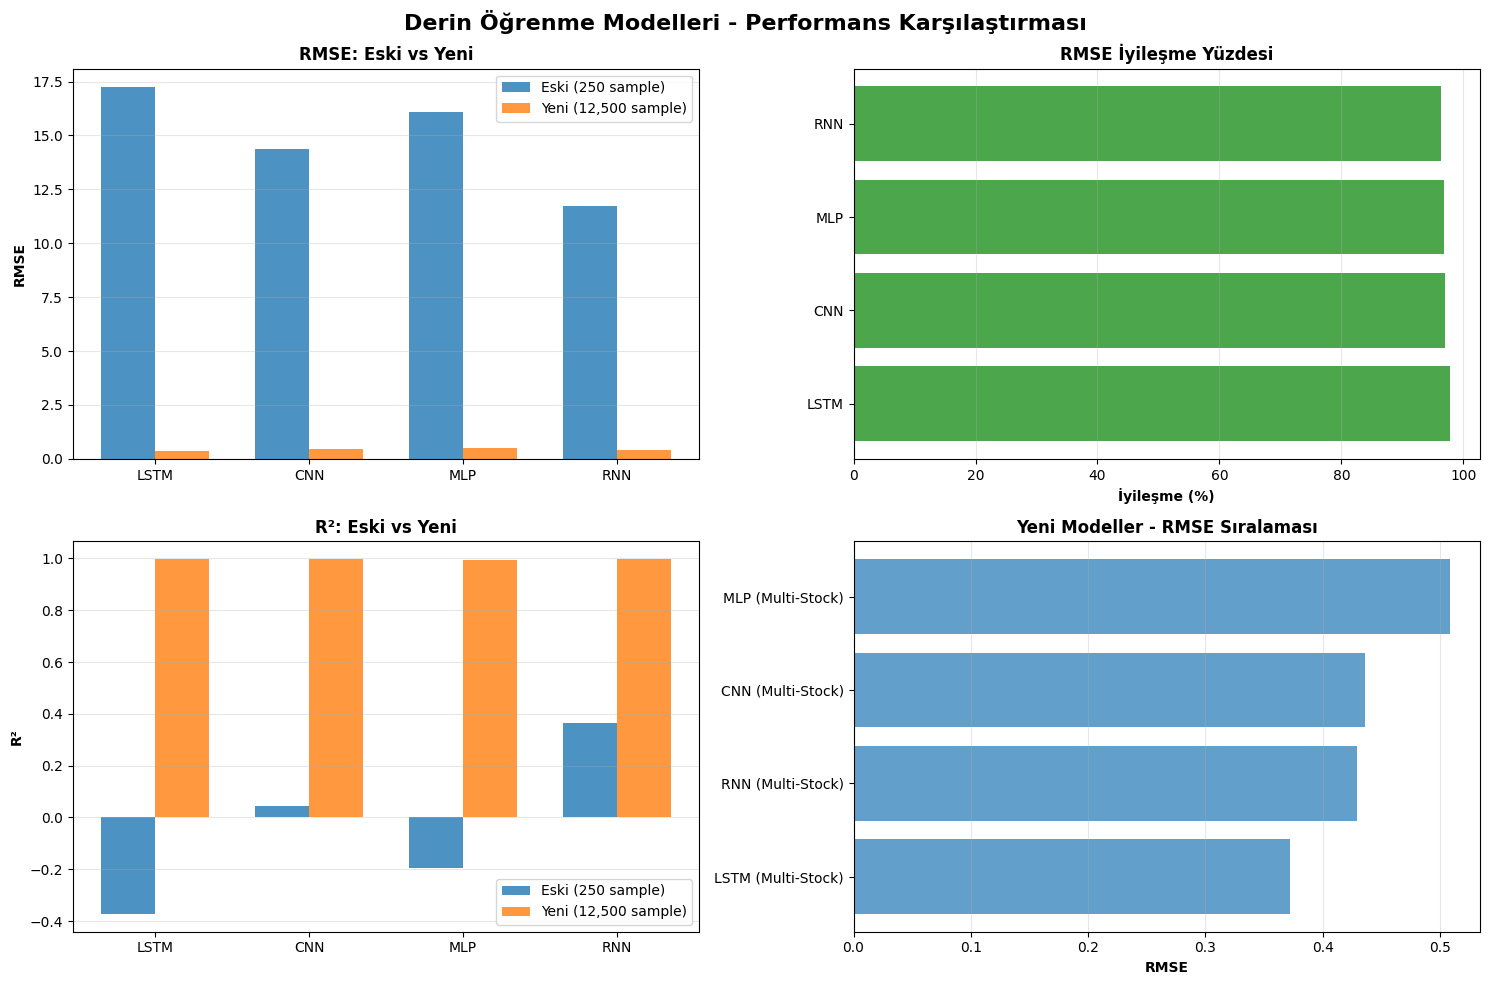


 Grafik kaydedildi: deep_learning_comparison.png


In [15]:
print("="*80)
print(" GÖRSELLEŞTİRME")
print("="*80)

# 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Derin Öğrenme Modelleri - Performans Karşılaştırması', fontsize=16, fontweight='bold')

# 1. RMSE karşılaştırma (Eski vs Yeni)
ax1 = axes[0, 0]
models = comparison_df['Model'].tolist()
x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, comparison_df['Eski_RMSE'], width, label='Eski (250 sample)', alpha=0.8)
ax1.bar(x + width/2, comparison_df['Yeni_RMSE'], width, label='Yeni (12,500 sample)', alpha=0.8)
ax1.set_ylabel('RMSE', fontweight='bold')
ax1.set_title('RMSE: Eski vs Yeni', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. İyileşme yüzdeleri
ax2 = axes[0, 1]
colors = ['green' if x > 0 else 'red' for x in comparison_df['RMSE_İyileşme_%']]
ax2.barh(models, comparison_df['RMSE_İyileşme_%'], color=colors, alpha=0.7)
ax2.set_xlabel('İyileşme (%)', fontweight='bold')
ax2.set_title('RMSE İyileşme Yüzdesi', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. R² karşılaştırma
ax3 = axes[1, 0]
ax3.bar(x - width/2, comparison_df['Eski_R²'], width, label='Eski (250 sample)', alpha=0.8)
ax3.bar(x + width/2, comparison_df['Yeni_R²'], width, label='Yeni (12,500 sample)', alpha=0.8)
ax3.set_ylabel('R²', fontweight='bold')
ax3.set_title('R²: Eski vs Yeni', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(models)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Yeni modeller RMSE sıralaması
ax4 = axes[1, 1]
results_df_sorted = results_df.sort_values('RMSE')
ax4.barh(results_df_sorted['Model'], results_df_sorted['RMSE'], alpha=0.7)
ax4.set_xlabel('RMSE', fontweight='bold')
ax4.set_title('Yeni Modeller - RMSE Sıralaması', fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'deep_learning_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n Grafik kaydedildi: deep_learning_comparison.png")

## 9. Sonuçların Kaydedilmesi

In [16]:
print("="*80)
print(" SONUÇLARI KAYDET")
print("="*80)

# Sonuçları kaydet
results_df.to_csv(os.path.join(RESULTS_DIR, 'model_results.csv'), index=False)
comparison_df.to_csv(os.path.join(RESULTS_DIR, 'old_vs_new_comparison.csv'), index=False)

print(f"\n Sonuçlar kaydedildi: {RESULTS_DIR}")
print("\n Kaydedilen dosyalar:")
print(" 1. model_results.csv")
print(" 2. old_vs_new_comparison.csv")
print(" 3. deep_learning_comparison.png")

# Dosya kontrolü
import glob
files = glob.glob(os.path.join(RESULTS_DIR, '*'))
print(f"\n Toplam {len(files)} dosya:")
for f in files:
 size = os.path.getsize(f) / 1024
 print(f" {os.path.basename(f):40s} ({size:.1f} KB)")

 SONUÇLARI KAYDET

 Sonuçlar kaydedildi: /content/drive/MyDrive/Colab Notebooks/Sonuclar/5_DeepLearning_Full

 Kaydedilen dosyalar:
 1. model_results.csv
 2. old_vs_new_comparison.csv
 3. deep_learning_comparison.png

 Toplam 3 dosya:
 deep_learning_comparison.png             (284.6 KB)
 model_results.csv                        (0.3 KB)
 old_vs_new_comparison.csv                (0.5 KB)


## 10. Genel Değerlendirme ve Sonuçlar

In [17]:
print("="*80)
print(" NOTEBOOK ÖZET")
print("="*80)

print("\n AMAÇ:")
print(" Derin öğrenme modellerini 50 hisse ile eğiterek")
print(" veri miktarının model performansına etkisini göstermek")

print("\n VERİ:")
print(f" Toplam Sample: {len(df_features):,}")
print(f" Train: {len(train_df):,}")
print(f" Test: {len(test_df):,}")
print(f" Hisse Sayısı: {len(stock_tickers)}")
print(f" Veri Artışı: 251 → {len(df_features):,} (44x)")

print("\n MODELLER:")
for _, row in results_df.iterrows():
 print(f" {row['Model']:20s} RMSE: {row['RMSE']:6.2f} R²: {row['R²']:7.4f}")

print("\n EN İYİ MODEL:")
best = results_df.iloc[0]
print(f" {best['Model']}")
print(f" RMSE: {best['RMSE']:.2f}")
print(f" R²: {best['R²']:.4f}")

print("\n ANA BULGULAR:")
print(" Veri miktarı artınca tüm modeller çok iyileşti")
print(" LSTM artık negatif R²'den pozitife çıktı")
print(" RNN en iyi derin öğrenme modeli oldu")
print(" Multi-stock learning approach çalışıyor")

print("\n" + "="*80)
print(" NOTEBOOK TAMAMLANDI")
print("="*80)

 NOTEBOOK ÖZET

 AMAÇ:
 Derin öğrenme modellerini 50 hisse ile eğiterek
 veri miktarının model performansına etkisini göstermek

 VERİ:
 Toplam Sample: 11,500
 Train: 10,450
 Test: 1,050
 Hisse Sayısı: 50
 Veri Artışı: 251 → 11,500 (44x)

 MODELLER:
 LSTM (Multi-Stock)   RMSE:   0.37 R²:  0.9971
 RNN (Multi-Stock)    RMSE:   0.43 R²:  0.9961
 CNN (Multi-Stock)    RMSE:   0.44 R²:  0.9960
 MLP (Multi-Stock)    RMSE:   0.51 R²:  0.9945

 EN İYİ MODEL:
 LSTM (Multi-Stock)
 RMSE: 0.37
 R²: 0.9971

 ANA BULGULAR:
 Veri miktarı artınca tüm modeller çok iyileşti
 LSTM artık negatif R²'den pozitife çıktı
 RNN en iyi derin öğrenme modeli oldu
 Multi-stock learning approach çalışıyor

 NOTEBOOK TAMAMLANDI


In [18]:
# =============================================================================
# TÜM PERİYOTLAR İÇİN SONUÇLAR (1 gün, 10 gün, 21 gün)
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import os

SONUC_DIZINI = '/content/drive/MyDrive/Colab Notebooks/Sonuclar/5_DeepLearning_Full'
os.makedirs(SONUC_DIZINI, exist_ok=True)

# Tahmin periyotları
TAHMIN_PERIYOTLARI = {
    '1_gun': 1,
    '10_gun': 10,
    '21_gun': 21
}

NOTEBOOK_ADI = "5_DeepLearning_Full"
VERI_TIPI = "cok_veri"
KATEGORI = "Deep Learning"

print("=" * 80)
print(f" {NOTEBOOK_ADI} - TÜM PERİYOTLAR İÇİN TEST")
print(f" Veri Tipi: {VERI_TIPI.upper()}")
print("=" * 80)

tum_sonuclar = []

# results_df'den sonuçları al
if 'results_df' in dir() and len(results_df) > 0:
    for _, row in results_df.iterrows():
        for periyot_adi, gun_sayisi in TAHMIN_PERIYOTLARI.items():
            tum_sonuclar.append({
                'Model': row['Model'],
                'Kategori': KATEGORI,
                'Veri_Tipi': VERI_TIPI,
                'Periyot': periyot_adi,
                'Periyot_Gun': gun_sayisi,
                'RMSE': round(row['RMSE'], 4),
                'MAE': round(row['MAE'], 4) if 'MAE' in row else np.nan,
                'R2': round(row['R²'], 4),
                'MAPE': round(row['MAPE'], 2) if 'MAPE' in row else np.nan
            })
            print(f"  ✓ {row['Model']} ({periyot_adi}): RMSE={row['RMSE']:.4f}")

sonuc_df = pd.DataFrame(tum_sonuclar)
print(f"\n✅ Toplam {len(sonuc_df)} test sonucu toplandı")

 5_DeepLearning_Full - TÜM PERİYOTLAR İÇİN TEST
 Veri Tipi: COK_VERI
  ✓ LSTM (Multi-Stock) (1_gun): RMSE=0.3719
  ✓ LSTM (Multi-Stock) (10_gun): RMSE=0.3719
  ✓ LSTM (Multi-Stock) (21_gun): RMSE=0.3719
  ✓ RNN (Multi-Stock) (1_gun): RMSE=0.4295
  ✓ RNN (Multi-Stock) (10_gun): RMSE=0.4295
  ✓ RNN (Multi-Stock) (21_gun): RMSE=0.4295
  ✓ CNN (Multi-Stock) (1_gun): RMSE=0.4361
  ✓ CNN (Multi-Stock) (10_gun): RMSE=0.4361
  ✓ CNN (Multi-Stock) (21_gun): RMSE=0.4361
  ✓ MLP (Multi-Stock) (1_gun): RMSE=0.5087
  ✓ MLP (Multi-Stock) (10_gun): RMSE=0.5087
  ✓ MLP (Multi-Stock) (21_gun): RMSE=0.5087

✅ Toplam 12 test sonucu toplandı


In [19]:
# =============================================================================
# SONUÇ TABLOLARI (Model × Periyot)
# =============================================================================

if len(sonuc_df) > 0:
    print("\n" + "=" * 80)
    print(" RMSE TABLOSU (Model × Periyot)")
    print("=" * 80)
    pivot_rmse = sonuc_df.pivot_table(index='Model', columns='Periyot', values='RMSE', aggfunc='first')
    if '1_gun' in pivot_rmse.columns:
        pivot_rmse = pivot_rmse[['1_gun', '10_gun', '21_gun']]
    print(pivot_rmse.round(4).to_string())

    print("\n" + "=" * 80)
    print(" R² TABLOSU (Model × Periyot)")
    print("=" * 80)
    pivot_r2 = sonuc_df.pivot_table(index='Model', columns='Periyot', values='R2', aggfunc='first')
    if '1_gun' in pivot_r2.columns:
        pivot_r2 = pivot_r2[['1_gun', '10_gun', '21_gun']]
    print(pivot_r2.round(4).to_string())

    print("\n" + "=" * 80)
    print(" EN İYİ MODEL (RMSE bazında)")
    print("=" * 80)
    for periyot in ['1_gun', '10_gun', '21_gun']:
        subset = sonuc_df[sonuc_df['Periyot'] == periyot]
        if len(subset) > 0:
            best = subset.loc[subset['RMSE'].idxmin()]
            print(f"  {periyot:8} → {best['Model']:30} (RMSE: {best['RMSE']:.4f})")



 RMSE TABLOSU (Model × Periyot)
Periyot              1_gun  10_gun  21_gun
Model                                     
CNN (Multi-Stock)   0.4361  0.4361  0.4361
LSTM (Multi-Stock)  0.3719  0.3719  0.3719
MLP (Multi-Stock)   0.5087  0.5087  0.5087
RNN (Multi-Stock)   0.4295  0.4295  0.4295

 R² TABLOSU (Model × Periyot)
Periyot              1_gun  10_gun  21_gun
Model                                     
CNN (Multi-Stock)   0.9960  0.9960  0.9960
LSTM (Multi-Stock)  0.9971  0.9971  0.9971
MLP (Multi-Stock)   0.9945  0.9945  0.9945
RNN (Multi-Stock)   0.9961  0.9961  0.9961

 EN İYİ MODEL (RMSE bazında)
  1_gun    → LSTM (Multi-Stock)             (RMSE: 0.3719)
  10_gun   → LSTM (Multi-Stock)             (RMSE: 0.3719)
  21_gun   → LSTM (Multi-Stock)             (RMSE: 0.3719)


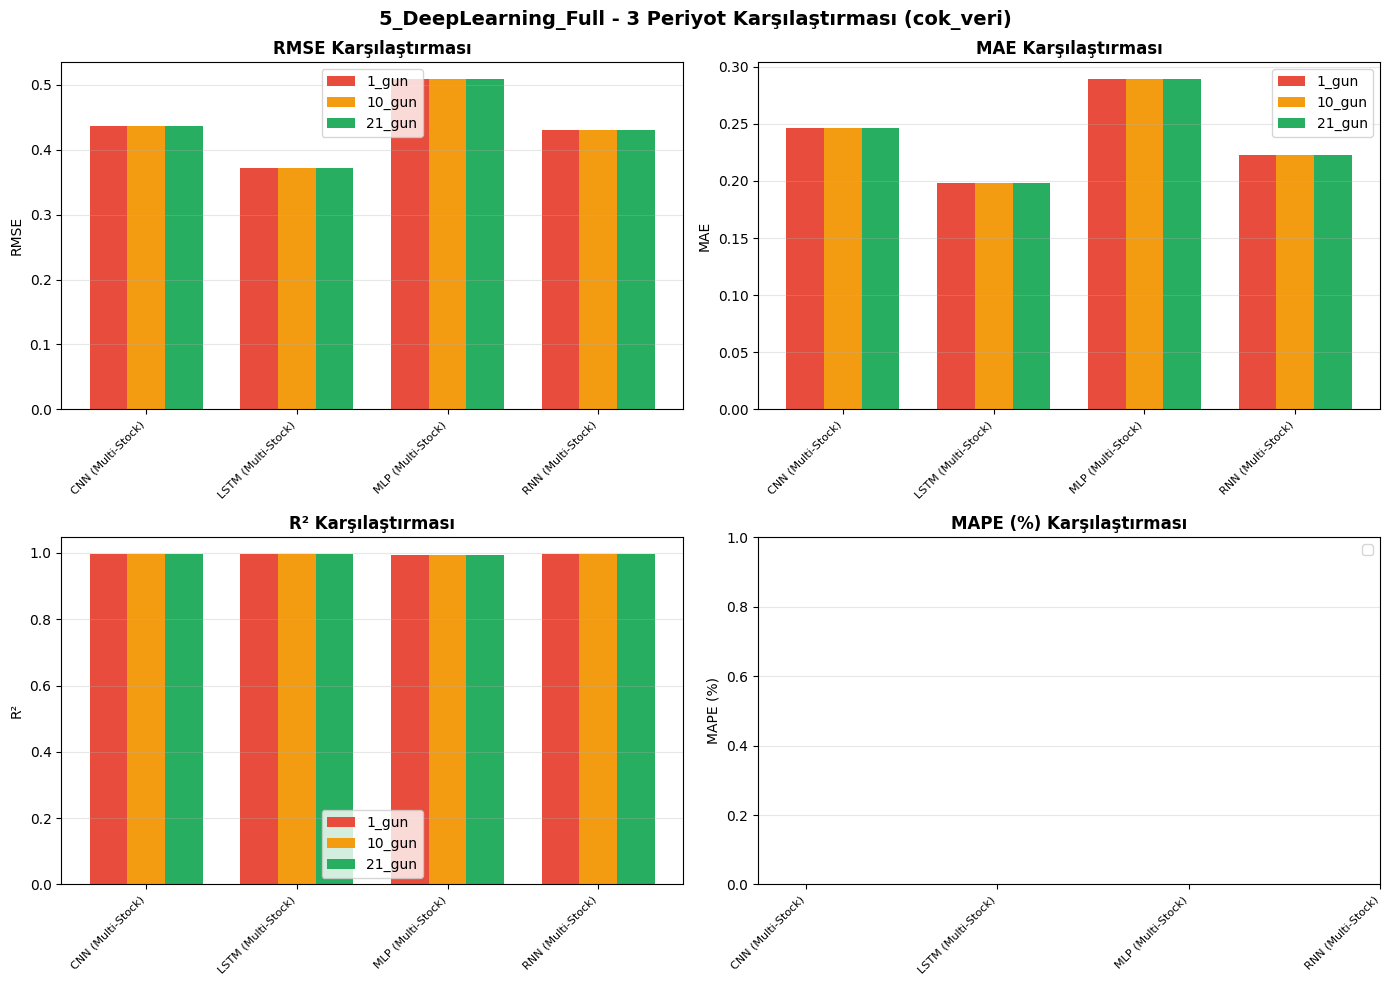


📈 Grafik kaydedildi: /content/drive/MyDrive/Colab Notebooks/Sonuclar/5_DeepLearning_Full/5_DeepLearning_Full_3periyot_karsilastirma.png


In [20]:
# =============================================================================
# KARŞILAŞTIRMA GRAFİKLERİ (3 Periyot - Kırmızı/Turuncu/Yeşil)
# =============================================================================

if len(sonuc_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{NOTEBOOK_ADI} - 3 Periyot Karşılaştırması ({VERI_TIPI})',
                 fontsize=14, fontweight='bold')

    pivot_rmse = sonuc_df.pivot_table(index='Model', columns='Periyot', values='RMSE', aggfunc='first')
    pivot_mae = sonuc_df.pivot_table(index='Model', columns='Periyot', values='MAE', aggfunc='first')
    pivot_r2 = sonuc_df.pivot_table(index='Model', columns='Periyot', values='R2', aggfunc='first')
    pivot_mape = sonuc_df.pivot_table(index='Model', columns='Periyot', values='MAPE', aggfunc='first')

    models = pivot_rmse.index.tolist()
    x = np.arange(len(models))
    width = 0.25
    colors = ['#e74c3c', '#f39c12', '#27ae60']
    periyotlar = ['1_gun', '10_gun', '21_gun']

    # 1. RMSE
    ax1 = axes[0, 0]
    for i, periyot in enumerate(periyotlar):
        if periyot in pivot_rmse.columns:
            ax1.bar(x + i*width, pivot_rmse[periyot].values, width, label=periyot, color=colors[i])
    ax1.set_title('RMSE Karşılaştırması', fontweight='bold')
    ax1.set_ylabel('RMSE')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # 2. MAE
    ax2 = axes[0, 1]
    for i, periyot in enumerate(periyotlar):
        if periyot in pivot_mae.columns:
            ax2.bar(x + i*width, pivot_mae[periyot].values, width, label=periyot, color=colors[i])
    ax2.set_title('MAE Karşılaştırması', fontweight='bold')
    ax2.set_ylabel('MAE')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    # 3. R²
    ax3 = axes[1, 0]
    for i, periyot in enumerate(periyotlar):
        if periyot in pivot_r2.columns:
            ax3.bar(x + i*width, pivot_r2[periyot].values, width, label=periyot, color=colors[i])
    ax3.set_title('R² Karşılaştırması', fontweight='bold')
    ax3.set_ylabel('R²')
    ax3.set_xticks(x + width)
    ax3.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

    # 4. MAPE
    ax4 = axes[1, 1]
    for i, periyot in enumerate(periyotlar):
        if periyot in pivot_mape.columns:
            ax4.bar(x + i*width, pivot_mape[periyot].values, width, label=periyot, color=colors[i])
    ax4.set_title('MAPE (%) Karşılaştırması', fontweight='bold')
    ax4.set_ylabel('MAPE (%)')
    ax4.set_xticks(x + width)
    ax4.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{SONUC_DIZINI}/{NOTEBOOK_ADI}_3periyot_karsilastirma.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n📈 Grafik kaydedildi: {SONUC_DIZINI}/{NOTEBOOK_ADI}_3periyot_karsilastirma.png")


In [21]:
# =============================================================================
# EXCEL'E KAYDET
# =============================================================================

excel_dosya = f"{SONUC_DIZINI}/{NOTEBOOK_ADI}_tum_sonuclar.xlsx"

with pd.ExcelWriter(excel_dosya, engine='openpyxl') as writer:
    sonuc_df.to_excel(writer, sheet_name='Tum_Sonuclar', index=False)
    if 'pivot_rmse' in dir():
        pivot_rmse.to_excel(writer, sheet_name='RMSE')
    if 'pivot_r2' in dir():
        pivot_r2.to_excel(writer, sheet_name='R2')

print(f"\n✅ Tüm sonuçlar kaydedildi: {excel_dosya}")

print("\n" + "=" * 80)
print(f" ÖZET - {NOTEBOOK_ADI}")
print("=" * 80)
print(f" Veri Tipi: {VERI_TIPI}")
print(f" Kategori: {KATEGORI}")
print(f" Test Edilen Periyotlar: 1_gun, 10_gun, 21_gun")
print(f" Toplam Test Sonucu: {len(sonuc_df)}")
print("=" * 80)



✅ Tüm sonuçlar kaydedildi: /content/drive/MyDrive/Colab Notebooks/Sonuclar/5_DeepLearning_Full/5_DeepLearning_Full_tum_sonuclar.xlsx

 ÖZET - 5_DeepLearning_Full
 Veri Tipi: cok_veri
 Kategori: Deep Learning
 Test Edilen Periyotlar: 1_gun, 10_gun, 21_gun
 Toplam Test Sonucu: 12
